<a href="https://colab.research.google.com/github/lawgorithm/timeseries/blob/update_OU/Simulate_an_OU_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ouparams

In [2]:
import numpy as np
from ouparams import ouparams
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def t_vector(T, dt):
    """Creates a vector of time points.

    Args:
        T (float): The end time of the time vector.
        dt (float): The time step size.

    Returns:
        numpy.ndarray: A vector of time points starting at 0 and ending at T with step size dt.
    """
    return np.arange(0, T, dt)

def simulate_ou(mu, theta, sigma, t, dt, x0):
    """Simulates an Ornstein-Uhlenbeck (OU) process.

    Args:
        mu (float): The long-term mean of the process.
        theta (float): The mean reversion rate.
        sigma (float): The volatility of the process.
        t (numpy.ndarray): The time points at which to simulate the process.
        dt (float): The time step size.
        x0 (float): The initial value of the process.

    Returns:
        numpy.ndarray: The simulated OU process values at the specified time points.
    """
    n = len(t)
    x = np.zeros(n)
    x[0] = x0
    dW = np.random.normal(0, np.sqrt(dt), size=n)
    for i in range(1, n):
        x[i] = x[i-1] + theta * (mu - x[i-1]) * dt + sigma * dW[i]
    return x

# OU Process example

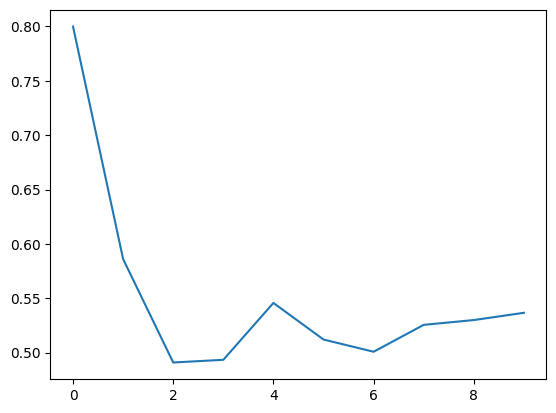

In [4]:
# Sample data (replace with your actual data)
data = np.array([
    0.8,
    0.58606434,
    0.49098481,
    0.49343492,
    0.54575029,
    0.51207641,
    0.50084814,
    0.52559959,
    0.53000366,
    0.53668143])
plt.plot(data)

In [5]:
# Estimate parameters using ouparams package
mu_est, sigma_est, theta_est = ouparams.find(data)

print("mu_est:", mu_est)
print("sigma_est:", sigma_est)
print("theta_est:", theta_est)

mu_est: 0.5171166243459767
sigma_est: 0.038885729337555484
theta_est: 1.5906939803229536


# Simulate an OU process

In [6]:
# Parameters

mu_sim = mu_est
sigma_sim = sigma_est
theta_sim = theta_est
T = int(1e3) # time duration, e.g. 100 days
dt = 0.1 # "mesh size" of the time step. E.g.
x0 = 1.25 * mu_est # Initial value
t_vec = t_vector(T, dt)

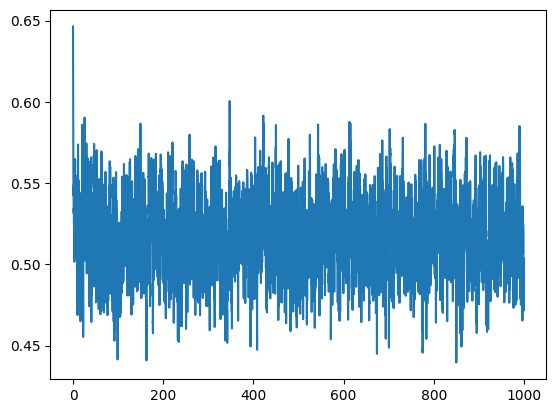

In [7]:
# Simulate an OU process

example_OU_draw = simulate_ou(mu_sim, theta_sim, sigma_sim, t_vec, dt, x0)
# Plot forecasts
plt.plot(
    t_vec,
    example_OU_draw,
    label='Example Draw of the OU stochastic process')

# Estimate the parameters of an OU process

### MLE for the OU parameters

We have the following model for the OU process:

$$ X_i \mid X_{i-1} \sim N(X_{i-1} + \theta (\mu - X_{i-1}) dt, dt \sigma^2) $$

We can rewrite to make this more convenient for estimation:

$$ X_i - X_{i-1} \sim N(\theta (\mu - X_{i-1}) dt, dt \sigma^2) $$

$$ \frac{X_i - X_{i-1}}{dt} \sim N(\theta \mu - \theta X_{i-1}, \frac{\sigma^2}{dt}) $$

This now looks like a simple linear regression problem. Recall the MLE for the linear regression model $Y \sim N(\alpha + \beta x, V)$:

$$ \hat{\beta} = \frac{\sum (x_i - \bar{x}) (y_i - \bar{y})}{\sum (x_i - \bar{x})^2}$$
$$ \hat{\alpha} = \bar{y} - \hat{\beta} \bar{x}$$
$$ \hat{V} = \frac{1}{n} \sum (y_i - \hat{\alpha} - \hat{\beta} x_i)^2$$

Now let's reparameterize to get the OU process parameter estimates:

$$ \hat{\theta} = - \hat{\beta}$$
$$ \alpha = \theta \mu \implies \hat{\mu} = \frac{\hat{\alpha}}{\hat{\theta}} $$
$$ V = \frac{\sigma^2}{dt} \implies \hat{\sigma^2} = dt \hat{V}$$

### Manual Maximum Likelihood Estimation of OU parameters

In [10]:
# Construct dataset for MLE estimation
df = pd.DataFrame({
    'x_prev' : example_OU_draw[:-1],
    'diffs': np.diff(example_OU_draw),
    'dt': dt
})

# Normalize
df['z'] = (df['diffs']) / df['dt']

df.head()

,x_prev,diffs,dt,z
0,0.646396,-0.012994,0.1,-0.129937
1,0.633402,-0.008026,0.1,-0.080261
2,0.625376,-0.023984,0.1,-0.239838
3,0.601392,-0.027908,0.1,-0.279080
4,0.573484,-0.022256,0.1,-0.222561


In [11]:
# Compute MLE for the regression parameters
beta_hat = df['z'].cov(df['x_prev']) / np.var(df['x_prev'])
alpha_hat = df['z'].mean() - beta_hat * df['x_prev'].mean()
V_hat = np.sum((df['z'] - beta_hat * df['x_prev'] - alpha_hat)**2) / len(df['z'])

In [12]:
# Use the regression MLE to get the MLE for the OU params
theta_hat = -beta_hat
mu_hat = alpha_hat / theta_hat
sigma_sq_hat = V_hat * dt
sigma_hat = np.sqrt(sigma_sq_hat)

In [13]:
# Check
print("mu_sim:", mu_sim)
print("sigma_sim:", sigma_sim)
print("theta_sim:", theta_sim)
print()
print(f'mu_hat: {mu_hat}')
print(f'sigma_hat: {sigma_hat}')
print(f'theta_hat: {theta_hat}')

mu_sim: 0.5171166243459767
sigma_sim: 0.038885729337555484
theta_sim: 1.5906939803229536

mu_hat: 0.516990474529963
sigma_hat: 0.038393057538299157
theta_hat: 1.587821412740725


In [8]:
# @title Note: ouparams Library seems broken. TODO: understand why

# Sanity check for the ouparams library
mu_sanity, sigma_sanity, theta_sanity = ouparams.find(example_OU_draw)

print("mu_sim:", mu_sim)
print("sigma_sim:", sigma_sim)
print("theta_sim:", theta_sim)
print()
print("mu_sanity:", mu_sanity)
print("sigma_sanity:", sigma_sanity)
print("theta_sanity:", theta_sanity)

mu_sim: 0.5171166243459767
sigma_sim: 0.038885729337555484
theta_sim: 1.5906939803229536

mu_sanity: 0.516990464999397
sigma_sanity: 0.013204248772919373
theta_sanity: 0.1728857283401431


# Confidence bounds via monte carlo simulations
### Note: I don't know whether this is valid, it's just an intuition
The main intuition is that, iIf you knew that your process was OU, you could run many simulations to get a sense of the 95\% interval for future outcomes. This is kind of like a point-wise parametric bootstrap for a prediction interval.

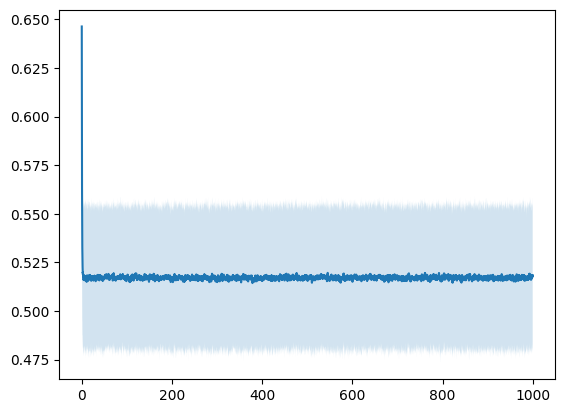

In [14]:
num_simulations = 1000

forecasts = np.zeros((num_simulations, len(t_vec)))
for i in range(num_simulations):
    x = simulate_ou(mu_est, theta_est, sigma_est, t_vec, dt, x0)
    forecasts[i, :] = x

# Calculate mean, median, and quantiles of forecasts
# I think the quantiles are basically pointwise CIs using a parametric boostrap
mean_forecast = np.mean(forecasts, axis=0)
lower_quantile = np.quantile(forecasts, 0.05, axis=0)
upper_quantile = np.quantile(forecasts, 0.95, axis=0)

# Plot forecasts
plt.plot(
    t_vec,
    mean_forecast,
    label='Median Forecast')
plt.fill_between(
    t_vec,
    lower_quantile,
    upper_quantile,
    alpha=0.2)
plt.show()

# Geometric OU examples

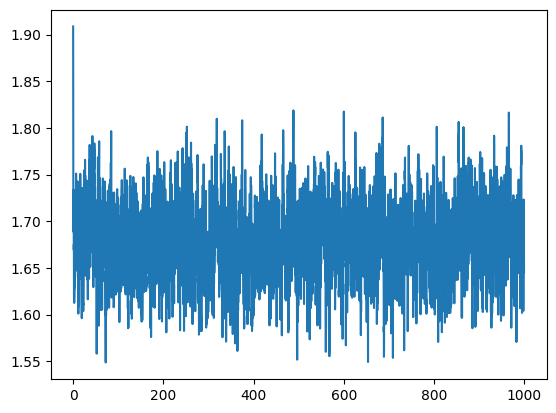

In [15]:
# OU Process example
example_geom_OU_draw = np.exp(simulate_ou(
    mu_est, theta_est, sigma_est, t_vec, dt, x0))
# Plot forecasts
plt.plot(
    t_vec,
    example_geom_OU_draw,
    label='Example Draw of the Geometric OU stochastic process')